# PCA analysis of batch effect in previously sequences (old) and recently obtained batches of MATseq transcriptomic profiles 

25th of October 2023

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sklearn.set_config(transform_output="pandas")
# %matplotlib inline

%reload_ext autoreload
%autoreload 2


In [54]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)

In [127]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.map(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


def to_normalize_rpm(data):
    # Normalise the gene counts to the library size
    data = data.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
    return data


def data_prep_pca(data):
    sample_names = data.index
    data = data.loc[:, data.sum(axis=0) > 10]
    data = to_normalize_DESeq2_style(data)
    data = np.log1p(data)
    data = scaler.fit_transform(data)

    return data


def data_prep_mlpc(data):  # the same steps as in the original MLPCseq pipeline
    sample_names = data.index
    # data = to_normalize_rpm(data) # original pipeline does not normalise samples (???)
    under10rpm = (
        open("/home/t.afanasyeva/MATseq/library/MLPC_model/MLPC_genes_under_10.txt")
        .read()
        .split("\n")
    )
    mask = data.T.index.isin(under10rpm)
    data = data.T[~mask]
    data = scaler.fit_transform(data)  # zscore uses the same formula as the scaler
    data = data.T

    return data


def get_classes_batches(data):
    classes = []
    batches = []
    for name in data.index:
        parts = name.split("_")
        if name.startswith("BA"):
            batches.append("7128_old")
            classes.append(parts[-2])
        else:
            classes.append(parts[-2])
            batches.append(parts[1])

    return classes, batches

In [56]:
sns.set_context(
    "paper",
    rc={
        "font.size": 12,
        "axes.titlesize": 8,
        "axes.labelsize": 12,
        "figure.figsize": (240, 160),
    },
)


custom_palette_12 = [
    "#000000",
    "#8b4513",
    "#006400",
    "#000080",
    "#ff0000",
    "#ffa500",
    "#00ff7f",
    "#00ffff",
    "#ff00ff",
    "#eee8aa",
    "#6495ed",
    "#ff69b4",
]


custom_palette_24 = [
    "#000000",
    "#696969",
    "#8b4513",
    "#808000",
    "#3cb371",
    "#00008b",
    "#8b008b",
    "#ff4500",
    "#ffa500",
    "#ffff00",
    "#7fff00",
    "#00ff7f",
    "#4169e1",
    "#dc143c",
    "#00ffff",
    "#00bfff",
    "#0000ff",
    "#d8bfd8",
    "#ff00ff",
    "#db7093",
    "#f0e68c",
    "#ff1493",
    "#ffa07a",
    "#ee82ee",
]

In [57]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_106_samples.csv"
data = pd.read_csv(file_name, index_col="sample")

In [58]:
file_name = (
    "/home/t.afanasyeva/MATseq/notebooks/gene_counts_exp_B34_B44_B51_B61_B64.csv"
)
data_old_batch = pd.read_csv(file_name, index_col="sample")

In [72]:
processed_data_pca = data_prep_pca(data)
processed_data_old_pca = data_prep_pca(data_old_batch)

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

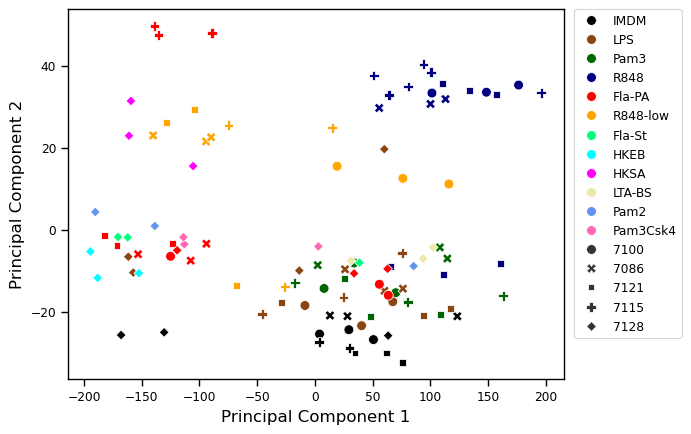

In [73]:
classes, batches = get_classes_batches(processed_data_pca)
data_pca = pca.fit_transform(processed_data_pca)

scatter = sns.scatterplot(
    x=data_pca.pca0,
    y=data_pca.pca1,
    hue=classes,
    style=batches,
    palette=custom_palette_12,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

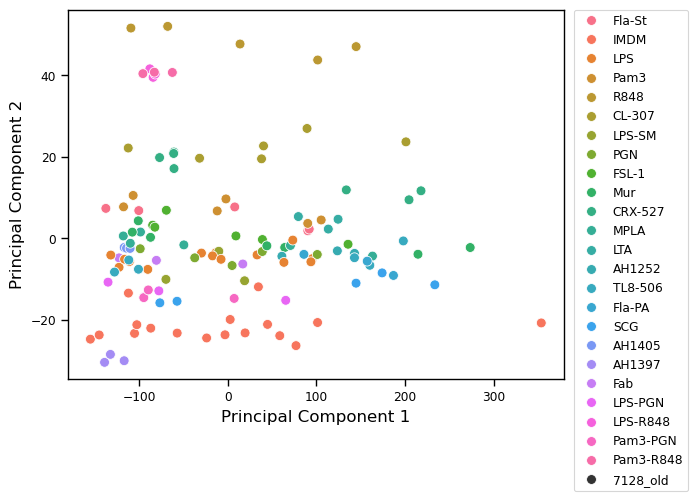

In [169]:
classes_old, batches_old = get_classes_batches(processed_data_old_pca)
data_old_pca = pca.fit_transform(processed_data_old_pca)

sns.set_context(
    "paper",
    rc={
        "font.size": 12,
        "axes.titlesize": 8,
        "axes.labelsize": 12,
        "figure.figsize": (240, 160),
    },
)


scatter = sns.scatterplot(
    x=data_old_pca.pca0,
    y=data_old_pca.pca1,
    hue=classes_old,
    style=batches_old,
    # palette=custom_palette_24,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [111]:
data_combined = pd.concat([data, data_old_batch])
classes_combined, batches_combined = get_classes_batches(data_combined)

In [101]:
data_combined

,HUNK,KLHL8,ZNF576,UGT1A5,FCF1,SLC2A7,FABP12,TAF12,GLRX,LAMB3,...,ASIC2,TSN,EVA1A,NFATC1,PORCN,GALNT17,DEPDC4,REL,RPL23,AHSP
sample,,,,,,,,,,,,,,,,,,,,,
MD211_7100_IMDM_1,0.0,59.0,34.0,0.0,95.0,0.0,0.0,63.0,42.0,166.0,...,0.0,255.0,0.0,203.0,9.0,0.0,0.0,1042.0,1903.0,0.0
MD211_7100_IMDM_2,0.0,84.0,13.0,0.0,204.0,0.0,0.0,31.0,24.0,107.0,...,0.0,128.0,0.0,141.0,13.0,0.0,0.0,1086.0,1540.0,1.0
MD211_7100_IMDM_3,0.0,33.0,15.0,0.0,121.0,0.0,0.0,47.0,26.0,75.0,...,0.0,169.0,0.0,138.0,9.0,0.0,0.0,800.0,1218.0,1.0
MD211_7100_LPS_1,0.0,55.0,41.0,0.0,135.0,0.0,0.0,53.0,46.0,131.0,...,0.0,143.0,0.0,181.0,17.0,0.0,0.0,870.0,1193.0,4.0
MD211_7100_LPS_2,0.0,75.0,45.0,0.0,196.0,0.0,0.0,49.0,69.0,177.0,...,0.0,317.0,0.0,233.0,17.0,0.0,0.0,1341.0,2254.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BA063_Pam3_17,0.0,277.0,95.0,0.0,532.0,0.0,0.0,157.0,184.0,760.0,...,0.0,802.0,0.0,909.0,60.0,0.0,1.0,5576.0,6945.0,1.0
BA063_Pam3_18,2.0,274.0,100.0,0.0,552.0,0.0,0.0,172.0,180.0,727.0,...,0.0,790.0,0.0,992.0,52.0,0.0,2.0,6483.0,7529.0,2.0
BA063_TL8-506_10,0.0,223.0,70.0,0.0,529.0,0.0,0.0,153.0,174.0,539.0,...,0.0,786.0,0.0,781.0,65.0,0.0,0.0,5673.0,6468.0,1.0


In [86]:
def subset_data(data, classes, classes_to_remove):
    data["classes"] = classes
    for i in classes_to_remove:
        data = data[data["classes"] != i]
    data = data.drop(columns="classes")

    return data

I only take classes that are present in the new set to compare the batches of the new and the old set.

In [102]:
classes_unique = list(set(classes))

classes_to_remove = []
for i in classes_combined:
    if i in classes_unique:
        continue
    else:
        classes_to_remove.append(i)
    classes_to_remove.append("HKEB")
    classes_to_remove.append("HKSA")

In [120]:
data_combined_subset = subset_data(data_combined, classes_combined, classes_to_remove)

classes_combined_subset, batches_combined_subset = get_classes_batches(
    data_combined_subset
)
processed_combined_data_pca = data_prep_pca(data_combined_subset)

In [128]:
processed_combined_data_mlpc = data_prep_mlpc(data_combined_subset)

/tmp/ipykernel_2823703/2002138511.py:3: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  scatter = sns.scatterplot(


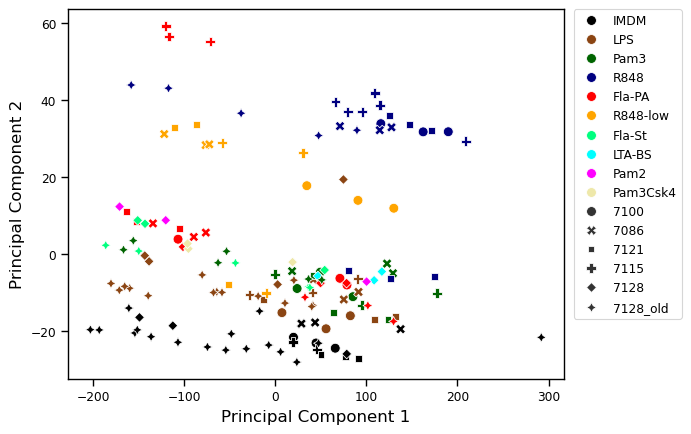

In [114]:
data_combined_subset_pca_pca = pca.fit_transform(processed_combined_data_pca)

scatter = sns.scatterplot(
    x=data_combined_subset_pca_pca.pca0,
    y=data_combined_subset_pca_pca.pca1,
    hue=classes_combined_subset,
    style=batches_combined_subset,
    palette=custom_palette_12,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [105]:
import pickle

model = pickle.load(
    open("/home/t.afanasyeva/MATseq/library/MLPC_model/MATseq_MLPC.model", "rb")
)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [129]:
X_test = processed_combined_data_mlpc

In [130]:
mlpc_results = pd.DataFrame(
    model.predict_proba(X_test), columns=list(model.classes_), index=list(X_test.index)
)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [131]:
mlpc_results

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
MD211_7100_IMDM_1,9.41352e-05,3.69950e-06,0.00093,9.44390e-01,0.05357,4.19768e-06,0.00100,1.12538e-05,4.99815e-11
MD211_7100_IMDM_2,3.21362e-04,2.73339e-06,0.00541,9.63137e-01,0.03063,8.76701e-06,0.00049,1.50975e-06,2.07378e-11
MD211_7100_IMDM_3,1.61371e-04,2.40698e-06,0.00249,9.67767e-01,0.02862,3.69613e-06,0.00095,3.46908e-06,2.02194e-11
MD211_7100_LPS_1,9.50698e-04,1.75270e-04,0.02048,1.74710e-01,0.78854,8.19103e-05,0.01479,2.77575e-04,1.33466e-09
MD211_7100_LPS_2,1.67584e-03,5.09224e-05,0.03202,2.66239e-01,0.69348,4.39595e-04,0.00591,1.85521e-04,2.01599e-09
...,...,...,...,...,...,...,...,...,...
BA063_LPS_5,5.05920e-04,1.51648e-04,0.00148,1.00445e-02,0.98239,2.20330e-05,0.00380,1.59830e-03,3.53740e-09
BA063_LPS_6,1.50504e-03,2.91348e-04,0.00494,8.47563e-03,0.98203,1.85127e-04,0.00222,3.56460e-04,3.49278e-09
BA063_Pam3_16,6.03622e-05,1.05734e-02,0.00086,1.19917e-06,0.00202,1.98207e-02,0.00095,9.65566e-01,1.47320e-04
BA063_Pam3_17,9.32081e-06,5.67583e-03,0.00009,7.14527e-07,0.00226,2.24760e-03,0.00115,9.88516e-01,4.42077e-05


In [132]:
mlpc_results["classes"] = classes_combined_subset
mlpc_results["batches"] = batches_combined_subset

In [134]:
mlpc_results

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848,classes,batches
MD211_7100_IMDM_1,9.41352e-05,3.69950e-06,0.00093,9.44390e-01,0.05357,4.19768e-06,0.00100,1.12538e-05,4.99815e-11,IMDM,7100
MD211_7100_IMDM_2,3.21362e-04,2.73339e-06,0.00541,9.63137e-01,0.03063,8.76701e-06,0.00049,1.50975e-06,2.07378e-11,IMDM,7100
MD211_7100_IMDM_3,1.61371e-04,2.40698e-06,0.00249,9.67767e-01,0.02862,3.69613e-06,0.00095,3.46908e-06,2.02194e-11,IMDM,7100
MD211_7100_LPS_1,9.50698e-04,1.75270e-04,0.02048,1.74710e-01,0.78854,8.19103e-05,0.01479,2.77575e-04,1.33466e-09,LPS,7100
MD211_7100_LPS_2,1.67584e-03,5.09224e-05,0.03202,2.66239e-01,0.69348,4.39595e-04,0.00591,1.85521e-04,2.01599e-09,LPS,7100
...,...,...,...,...,...,...,...,...,...,...,...
BA063_LPS_5,5.05920e-04,1.51648e-04,0.00148,1.00445e-02,0.98239,2.20330e-05,0.00380,1.59830e-03,3.53740e-09,LPS,7128_old
BA063_LPS_6,1.50504e-03,2.91348e-04,0.00494,8.47563e-03,0.98203,1.85127e-04,0.00222,3.56460e-04,3.49278e-09,LPS,7128_old
BA063_Pam3_16,6.03622e-05,1.05734e-02,0.00086,1.19917e-06,0.00202,1.98207e-02,0.00095,9.65566e-01,1.47320e-04,Pam3,7128_old
BA063_Pam3_17,9.32081e-06,5.67583e-03,0.00009,7.14527e-07,0.00226,2.24760e-03,0.00115,9.88516e-01,4.42077e-05,Pam3,7128_old


,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
MD211_7100_IMDM_1,9.41352e-05,3.69950e-06,0.00093,9.44390e-01,0.05357,4.19768e-06,0.00100,1.12538e-05,4.99815e-11
MD211_7100_IMDM_2,3.21362e-04,2.73339e-06,0.00541,9.63137e-01,0.03063,8.76701e-06,0.00049,1.50975e-06,2.07378e-11
MD211_7100_IMDM_3,1.61371e-04,2.40698e-06,0.00249,9.67767e-01,0.02862,3.69613e-06,0.00095,3.46908e-06,2.02194e-11
MD211_7100_LPS_1,9.50698e-04,1.75270e-04,0.02048,1.74710e-01,0.78854,8.19103e-05,0.01479,2.77575e-04,1.33466e-09
MD211_7100_LPS_2,1.67584e-03,5.09224e-05,0.03202,2.66239e-01,0.69348,4.39595e-04,0.00591,1.85521e-04,2.01599e-09
...,...,...,...,...,...,...,...,...,...
BA063_LPS_5,5.05920e-04,1.51648e-04,0.00148,1.00445e-02,0.98239,2.20330e-05,0.00380,1.59830e-03,3.53740e-09
BA063_LPS_6,1.50504e-03,2.91348e-04,0.00494,8.47563e-03,0.98203,1.85127e-04,0.00222,3.56460e-04,3.49278e-09
BA063_Pam3_16,6.03622e-05,1.05734e-02,0.00086,1.19917e-06,0.00202,1.98207e-02,0.00095,9.65566e-01,1.47320e-04
BA063_Pam3_17,9.32081e-06,5.67583e-03,0.00009,7.14527e-07,0.00226,2.24760e-03,0.00115,9.88516e-01,4.42077e-05


Text(49.916666666666664, 0.5, 'Sample')

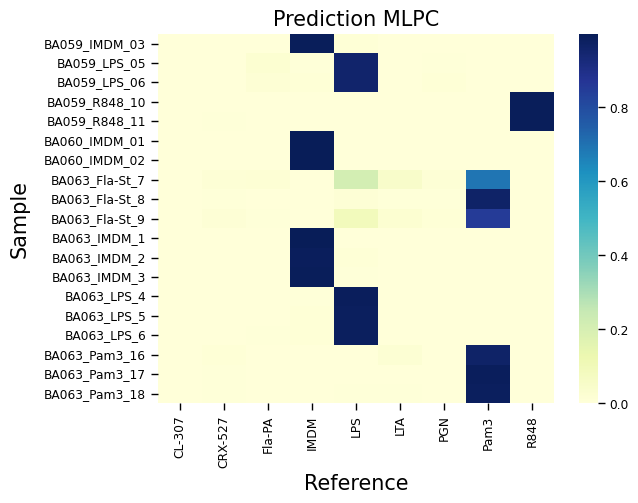

In [168]:
heat = sns.heatmap(mlpc_results.iloc[130:149, :-2], cmap="YlGnBu")

# Adjust layout for the second plot
heat.set_title(f"Prediction MLPC", fontsize=15)
heat.set_xlabel("Reference", fontsize=15)
heat.set_ylabel("Sample", fontsize=15, labelpad=10)

In [ ]:
subset_7086 = data_combined_single_class[
    data_combined_single_class["batches"] == "7086"
]
subset_7100 = data_combined_single_class[
    data_combined_single_class["batches"] == "7100"
]
subset_7115 = data_combined_single_class[
    data_combined_single_class["batches"] == "7115"
]
subset_7121 = data_combined_single_class[
    data_combined_single_class["batches"] == "7121"
]
subset_7128 = data_combined_single_class[
    data_combined_single_class["batches"] == "7128"
]
subset_7128_old = data_combined_single_class[
    data_combined_single_class["batches"] == "7128_old"
]

subset_7128_commbined = pd.concat([subset_7128, subset_7128_old], axis=0)

In [135]:
unique_batches = list(set(mlpc_results["batches"]))
unique_classes = list(set(mlpc_results["classes"]))

{'7086', '7100', '7115', '7121', '7128', '7128_old'}

In [142]:
data_names_classes = []
for j in unique_classes:
    data_names_classes.append(f"subset_{j}")

['subset_Pam2',
 'subset_LTA-BS',
 'subset_Pam3Csk4',
 'subset_IMDM',
 'subset_Fla-PA',
 'subset_R848',
 'subset_LPS',
 'subset_R848-low',
 'subset_Pam3',
 'subset_Fla-St']

In [144]:
for i in data.index:
    for j in unique_classes:
        for z in data_names_classes:
            if i.split("_")[-2] == j and z.split("_")[1] == j:
                f"{z}" = data.loc[j]
                


SyntaxError: cannot assign to f-string expression here. Maybe you meant '==' instead of '='? (4104245551.py, line 5)

NameError: name 'X_pca' is not defined

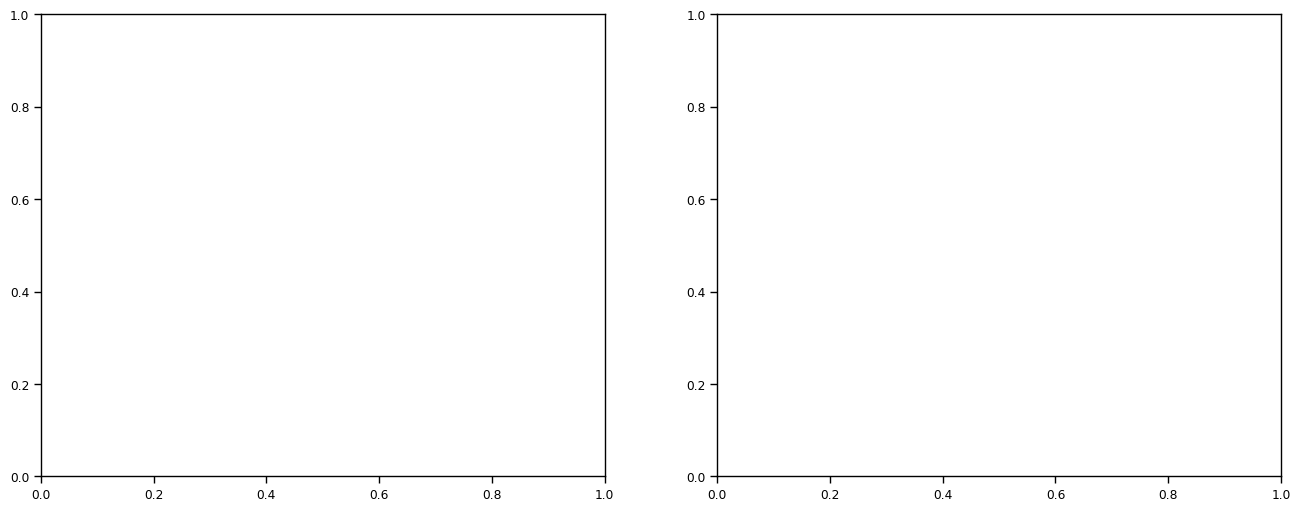

In [139]:
dict
for index, batch in enumerate(batches_combined_subset):
    for unique_batch in unique_batches:
        if batch == unique_batch:
            name = f"subset_{batch}"

In [ ]:
            
        
    
        
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    pca = pca.fit_transform(X_pca)


    scatter = sns.scatterplot(
        x=pca.pca0,
        y=pca.pca1,
        hue=subset.classes,
        style=subset.batches,
        palette=custom_palette_12,
        s=50,
        ax=axes[0],
    )

    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    axes[0].set_title(f"PCA Plot", fontsize=15)

    mlpc_results

    ax = sns.heatmap(mlpc_results, cmap="YlGnBu")


    # Adjust layout for the second plot
    axes[1].set_title(f"Prediction MLPC for batch {name}", fontsize=15)
    axes[1].set_xlabel("Reference", fontsize=15)
    axes[1].set_ylabel("Sample", fontsize=15, labelpad=10)

    # Adjust overall layout
    plt.tight_layout()

    # Show or save the plot
    plt.show()  # Use plt.savefig("your_filename.png") to save the plot to a file

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_context(
    "paper", rc={"font.size": 12, "axes.titlesize": 8, "axes.labelsize": 12}
)

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


sc = ax.scatter(
    xs=data_pca["pca0"],
    ys=data_pca["pca1"],
    zs=data_pca["pca2"],
    s=70,
    marker="o",
    c=classes_merege_encode,
    alpha=1,
)

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")